In [7]:
# install RISE with https://rise.readthedocs.io/en/stable/installation.html
#!pip3 install -U scikit-learn
#!pip3 install -U RISE
#!pip3 install -U matplotlib
#!pip3 install -U numpy
# all imports
# !pip3 install -U tensorflow
from sklearn.feature_extraction.text import CountVectorizer
import math 
import matplotlib.pyplot as plt
import numpy as np

# Chapter 6: Specific Problem of Natural Language Processing

## by Ziwei Chen, Stephan Nef, Lukas Bamert and Jan Grau

# Agenda

1. Words to mathematical representation
2. Embedding the problem into already learnt
3. Transformer Encoder
    1. Self-Attention
    2. position-wise Feedforward Networks
    3. Residucal connection and Layer Normalization

# Introduction to NLP

### What is NLP?
  The study of language interactions from a computational perspective, enabling the development of algorithms and models capable of natural language understanding and natural language generation 
 
### Application areas:
- Extracting information from text 
- Translating or generating text 
- Full conversational systems(e.g.chatbots or personal assistants)



## Words to mathematical representation

### Problems of word to NLP
- For a language processing system based on a real-valued representation (such as neural networks), all input data must first be transformed into a numerical representation
-  Unlike numerical data or data that already have an inherent numerical structure, such as images where each pixel can be specified by a vector of values for each color channel (e.g. three values for RGB) 
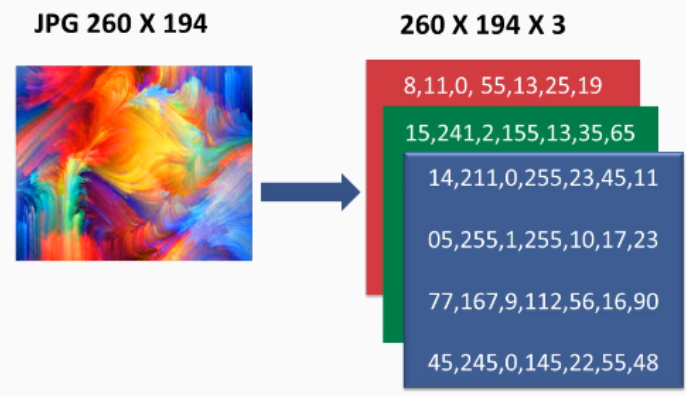


### Discrete representation
#### Transformation of text into a sequence of real-valued vectors

1. A simple vector representation of a given word can be created by constructing a vocabulary $V$ which contains a list of all potential words.

2. Each word $w_i$ to its index $i$ in the vocabulary. Like one-hot encoding vectors. 

$\qquad w_i \in V \qquad  \Longrightarrow \qquad t_i = [o_{i1},...,o_{iv}]$
- $ o_{ij} = 1 \; for\;  i = j;\;and$
- $ o_{ij} = 0 \; for\; i \neq j$


In [8]:
# create CountVectorizer object
vectorizer = CountVectorizer()
corpus = [
          'Text of first Lukas.',
          'Text of the second document made longer.',
          'Number three is new.',
          'This is number four.',
]
# learn the vocabulary and store CountVectorizer sparse matrix in X
X = vectorizer.fit_transform(corpus)# columns of X correspond to the result of this method
print(vectorizer.get_feature_names_out())
print(X.toarray())# transforming a new document according to learn vocabulary
vectorizer.transform(['A new Lukas is three.']).toarray()


['document' 'first' 'four' 'is' 'longer' 'lukas' 'made' 'new' 'number'
 'of' 'second' 'text' 'the' 'this' 'three']
[[0 1 0 0 0 1 0 0 0 1 0 1 0 0 0]
 [1 0 0 0 1 0 1 0 0 1 1 1 1 0 0]
 [0 0 0 1 0 0 0 1 1 0 0 0 0 0 1]
 [0 0 1 1 0 0 0 0 1 0 0 0 0 1 0]]


array([[0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1]], dtype=int64)

### Limitations of discrete word transformation as calculated above
- They only capture information about a word’s position in the vocabulary, not in each sentance, which can be arbitrary
- They do not allow mathematical definition of similarity. 

### Distributed representation

- Capture the syntactic and semantic information of a word
- Preserve semantic similarity (e.g. approximately, about)
- Model their usage in different contexts (e.g. bear)



###  Co-occurrence matrix
  Pairwise count values on how many times two words appear together in a specific context window.  
  
  
**Example**  
       *Corpus:*   
        "I like deep learning"  
        "I like NLP",  
        "I enjoy flying"

<img src="attachment:image.png" width=50% style="margin-left:auto; margin-right:auto">


### Words Embedding
- Iterating over all words in the entire corpus.
- Predicting the probability of a proximal word using that word.
- Updating the gradient by learning
    
    $x_i = Mt_i$ 
    
    In weight matrix $M(V*d)$, where $V$ is number of words and $d$ is embedding dimension.   
    Embedding vector $x_i$ corresponds to the $i$-th row and $t_i$ is the one hot encoded vector for word $w_i$.
    
    $x_i^\star= x_i +p_j$
    
    Additional learned vector $p_j$ (or position embedding), same words occur in different position, to find out the relative position by learning .  
   
    
    

### Semantic Similarity    
    Semantic-focused natural language processing needs to have the ability to identify which semantic representations are close to each other.
#### Mathematical represent semantic similarity:
$\qquad w_{AB} = v_A'v_B$   

    Where word A is encoded by vector $v_A$ and word B by vector $v_B$, their similarity can be measure by their vector product

#### Example of Projection:
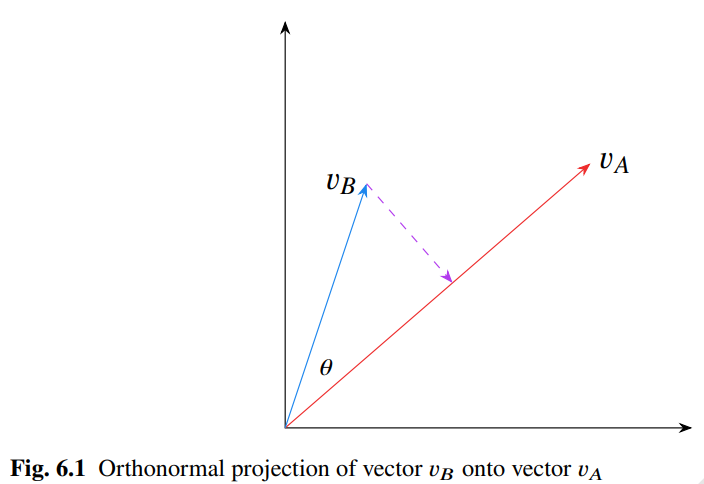

$v_{B|A} = \frac{v_Av_A'}{||v_A||}v_B = \frac{v_Av_A'}{v_A'v_A}v_B = v_A \frac{v_A'v_B}{||v_A||} = \frac{v_A}{||v_A||}w_{AB} $  

 **The normalized cosine similarity:**   
$ w_{AB}^\star =\frac{ v_A'v_B }{||v_A|| ||v_B||} = \frac{ v_A'v_B }{v_A'v_Av_Bv_B'}$


In [11]:
import gensim
from gensim.utils import simple_preprocess
from gensim.models import KeyedVectors
from gensim import corpora
from pprint import pprint
import numpy as np

documents = ["Honestly, I don’t understand anything anymore", 
             "Miller said.",
             "With all due respect to Messi and the other great players named,",
             "no one deserved it as much as Lewandowski.", 
             "To be as remarkable as the Bavarian striker.",
             "Lewandowski numbers do look better on paper"]

texts = [[text for text in doc.split()] for doc in documents]
dictionary = corpora.Dictionary(texts)

mycorpus = [dictionary.doc2bow(doc, allow_update=True) for doc in texts]

from gensim.models.word2vec import Word2Vec
model = Word2Vec(sentences=texts, vector_size=8, window=5, min_count=1, workers=4)
vector_word1 = model.wv['Messi']
vector_word2 = model.wv['Lewandowski']
vector_word3 = model.wv['Miller']
cos_sim1 = np.dot(vector_word1, vector_word2)/(np.linalg.norm(vector_word1)*np.linalg.norm(vector_word2))
cos_sim2 = np.dot(vector_word2, vector_word3)/(np.linalg.norm(vector_word2)*np.linalg.norm(vector_word3))
print(cos_sim1)
print(cos_sim2)

0.56623656
0.19450922


## Embed previous learnt methods to NLP



### modelling it as FIR
- draw some relations back to FIR with an example and image

### modelling it as IIR
- draw some relations back to IIR with an example and image

### modelling it as RNN
- draw some relations back to discrete linear systems with an example and image
- introduce the new formula $h_t = H(h_{t-1}, x_{t-1})$ and $y_t = Y(h_t,x_t)$
- explain the differences between classical RNNs and our application
- also with the new formula $h_t = H(h_{t-1}, x_{t})$ and $y_t = Y(h_t)$
- explain the vanishing gradient problem in RNN

## from RNN to LSTMs
- introduce the state formula $c_t = C(h_{t-1}, x_t, c_{t-1})$
- introduce formula 6.13
- introduce the three gates (forget gate, input gate and output gate)

In [10]:
# code to show the Hadamard operator

In [11]:
# code to explain the gates (if easily found)

### improvements for RNNs
- bidirectional sequencing
- example with BERT

![Attention is all you need](attention.jpg)

### Attention

Remember the problem of FIR filters? The length of the filter is too short for the actual input and quality of the data of the input may differ.

There is a solution to this: $\underline{attention}$.

Let $v = [v_1,..., v_n]$ be a sequence of input vectors.

Then we can define a context vector $c$ as $c= \sum_{i=1}^n \alpha_iv_i$.

This can be extrapolated to different context vectors, each describing different contexts $j$:

$$c_j = \sum_{i=1}^n \alpha_{ji}v_i $$


where $\alpha_{ji}$ is an attention weight from input $i$ to output $j$. A good way to achieve this is to use the softmax function:

$$\alpha_{ji} = \frac{e^{g_{ji}}}{\sum_{k=1}^ne^{g_{jk}}}$$

where $g_{ji}$ is using an alignment model to tell about the similarity of two vectors:

$$ g_{ji} = \frac{q_j'k_i}{\sqrt{k}}$$


In [1]:
# a context vector calculation in pratice

# let's try to figure out the market value of newcomer Güven 
# given our scouting DB with current market values of known players

v = {}
v["messi"] = 80
v["lewandowski"] = 40
v["maguire"] = -25

# since we already have an example of cosine similarity g_ji is given here

g = {}
g["güven-messi"] = 0.8
g["güven-lewandowski"] = 0.5
g["güven-maguire"] = -0.8

In [3]:
import math
import numpy as np

# a litte helper
sum_eg = 0
for mv in g:
    sum_eg += math.exp(g[mv])

# calculate attention values
alpha_güven_messi = math.exp(g["güven-messi"])/sum_eg
alpha_güven_lewandowski = math.exp(g["güven-lewandowski"])/sum_eg
alpha_güven_maguire = math.exp(g["güven-maguire"])/sum_eg
c = alpha_güven_messi *v["messi"] + alpha_güven_lewandowski * v["lewandowski"] + alpha_güven_maguire * v["maguire"]
print("expected market value of Güven: ", round(c,2), "Mio CHF")

expected market value of Güven:  53.83 Mio CHF


### Takeaway

We calculate basic attention by querying (Güven aka $q$) to keys (Messi & co, aka $k$) to get a value (market value aka $v$).

### Autocoding out of context

Tell something about chapter 6.6. But probably after transformers are explained.

## Self-Attention

What if we try to calculate our $q$, $k$, and $v$ by ourselves?

This process is called self-attention, where each input vector from $x = [x_1,...,x_n]$ is also query, key and value:

$$x_i = q_i = k_i = v_i$$

However instead of just calculating $c_j = \sum_{i=1}^n \alpha_{ji}v_i$ with $\alpha_{ji} = \frac{e^{g_{ji}}}{\sum_{k=1}^ne^{g_{jk}}}$, it has been proven mathematically beneficial to linearly project these vectors (in our example we had a scalar value) into smaller dimensionalities. For this we use three projection matrices $W^Q$, $W^K$, $W^V$. This will give us the following equations:

$$ q_i^\star = W^Qq_i, k_i^\star = W^Kk_i,v_i^\star = W^Vv_i$$


These $W$ play an essential role in the learning. Since the attention mechanism does not contain trainable parameters. Therefore given fixed inputs vectors, we need to learn the elements of the $W$'s. Also note that having two different matrices $W^Q$ and $W^K$ we will have asymetric relationships between the input vector elements.

In the end we can calculate $c_j =  \sum_{i=1}^n \alpha_{ji}v_i^\star$ for each element $x_i$.

In [60]:
import random
# input vector (maybe take values from Stephan/Ziwei)
x = np.array([np.random.random_sample(8) for x in range(3)])

# we need to set the dimensions
d_model = len(x[0]) # always the length of the input vectors
d_q = d_model // 4 # theoretically freely choosable to linear transform the projection matrix
d_v = d_model // 2 # can be different for the values, but usually not

# generate the three projections matrices
W_Q = np.random.random_sample((d_q, d_model)) # in a trainable model, those would be trained instead of random
W_K = np.random.random_sample((d_q, d_model)) # in a trainable model, those would be trained instead of random
W_V = np.random.random_sample((d_v, d_model)) # in a trainable model, those would be trained instead of random

print(W_Q.shape)

(2, 8)


In [61]:
# calculate context vector c_1 (based on x_1)
c_1 = 0
c = np.zeros((x.shape[0], d_v))


k_stars = np.array([np.dot(W_K, xi) for xi in x])
q_stars = np.array([np.dot(W_Q, xi).transpose() for xi in x])
v_stars = np.array([np.dot(W_V, xi) for xi in x])

for j in range(x.shape[0]):
    qj_star = q_stars[j]
    all_gj = np.array([np.dot(qj_star, k_stars[i]) / np.sqrt(d_model) for i in range(x.shape[0])]) # 3x1
    sum_g = np.sum(np.array([math.exp(all_gj[i]) for i in range(x.shape[0])]))
    alpha_j = np.array([math.exp(all_gj[i]) / sum_g for i in range(x.shape[0])])
    c[j] = np.sum([np.dot(alpha_j[i], v_stars[i]) for i in range(x.shape[0])], axis=0)
print(c.shape)

(3, 4)


## Multihead Attention
Theory

In [88]:
import random
# input vector (maybe take values from Stephan/Ziwei)
x = np.array([np.random.random_sample(8) for x in range(3)])

# we need to set the dimensions
d_model = len(x[0]) # always the length of the input vectors
d_q = d_model // 4 # theoretically freely choosable to linear transform the projection matrix
d_v = d_model // 2 # can be different for the values, but usually not
h_count = 3 # Header Count

W_Q = np.random.random_sample((h_count,d_q, d_model))
W_K = np.random.random_sample((h_count,d_q, d_model))
W_V = np.random.random_sample((h_count,d_v, d_model))


c_jh = np.zeros((x.shape[0], h_count, d_v))

for hi in range(h_count):
    k_stars = np.array([np.dot(W_K[hi], xi) for xi in x])
    q_stars = np.array([np.dot(W_Q[hi], xi).transpose() for xi in x])
    v_stars = np.array([np.dot(W_V[hi], xi) for xi in x])
    
    for j in range(x.shape[0]):
        qj_star = q_stars[j]
        all_gj = np.array([np.dot(qj_star, k_stars[i]) / np.sqrt(d_model) for i in range(x.shape[0])]) # 3x1
        sum_g = np.sum(np.array([math.exp(all_gj[i]) for i in range(x.shape[0])]))
        alpha_j = np.array([math.exp(all_gj[i]) / sum_g for i in range(x.shape[0])])
        c_jh[j][hi] = np.sum([np.dot(alpha_j[i], v_stars[i]) for i in range(x.shape[0])], axis=0)

W_O = np.random.random_sample((x.shape[0],d_model, h_count*d_v))

z = np.zeros((x.shape[0], d_model))
c = c_jh.reshape(x.shape[0], h_count * d_v)

for i in range(x.shape[0]):
    z[i] = np.dot(W_O[i], c[i])



                            


(3, 8)


## Pointwise Feedforward Network


In [97]:
d_inner = d_model * 4

W_1 = np.random.random_sample((d_inner, d_model))
W_2 = np.random.random_sample((d_model, d_inner))
b_1 = np.random.random_sample((d_inner))
b_2 = np.random.random_sample((d_model))
relu = np.zeros((d_inner))
y = np.zeros((x.shape[0], d_model))
for i in range(x.shape[0]):
    hidden_layer = np.maximum(np.dot(W_1, z[i] ) + b_1, d_inner)
    y[i] = np.dot(W_2, hidden_layer) + b_2
print("Y", y.shape)


Y (3, 8)


## Residual Connection and Layer Optimization

- aim to improve the converge of optimzation algorithms



## Residual Connection

Substitue $y = f(x,p)$ by $y = x + g(x,q)$ where q and p are parameter vectors

This means that $g(x,q) = f(x,p) - x$

- $ g(x,q)$ can be easier to optimize if f is close to the identity function $id(x) = x$
- $ q(x,q)$ learns how much the input x needs to change

- if $initial weights = 0$ without residual, then $output\approx zerofunction$
- if $initial weights = 0$ with residual, then $output \approx identity(x)$


Reasoning:

- gradient of objective function E ( Error function) $E(y)$.
- Chain-Rule
$$ E'(y) = E'(y)\cdot y'$$


$$ \frac{\delta E}{\delta y} = \frac{\delta E}{\delta y} \frac{\delta y}{\delta x}$$

Without residual: y = Px

$$ \frac{\delta E}{\delta y} \frac{\delta y}{\delta x} = \frac{\delta E}{\delta y}P$$

With residual connection: y = x + Qx, I = Identy Matrix (derivate of x)

$$ \frac{\delta E}{\delta y} \frac{\delta y}{\delta x} = \frac{\delta E}{\delta y}(I+Q)$$ 

In [160]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,3))
result = layers.MultiHeadAttention(key_dim=2, num_heads=2, use_bias=False, kernel_initializer='zeros')(inputs, inputs)
#result = layers.Add()([inputs, result])
model = keras.models.Model(inputs=inputs, outputs=result)
test_input = tf.constant([[[1,2,3]]])
result = model(test_input)
print(result)





tf.Tensor([[[0. 0. 0.]]], shape=(1, 1, 3), dtype=float32)
